# Загрузка

In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter
from sklearn.impute import MissingIndicator
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

from scipy.stats import mannwhitneyu

from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, roc_auc_score
from scipy import stats
#%pylab inline

In [128]:
# Url of the raw csvs file on GitHub
csv_url = 'https://raw.githubusercontent.com/avladova/Student-performance-prediction/main/engl_groups.csv'
# Read the xls file into a DataFrame
#raw = pd.read_csv(url)
raw = pd.read_csv(
    csv_url,
    decimal='.',          # Десятичный разделитель (запятая)
    sep=',',              # Разделитель столбцов (по умолчанию ',')
    na_values=['-', ''],  # Трактует '-' и пустые строки как NaN
    encoding='utf-8',     # Кодировка (если есть кириллица)
    skipinitialspace=True # Удаляет пробелы после разделителя
)
# Удаляем полностью пустые столбцы и строки
raw = raw.dropna(how='all', axis=1).dropna(how='all', axis=0)
raw.drop(columns='Email address', inplace=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 60 columns):
 #   Column                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                          --------------  -----  
 0   Пол                                                                                                                             50 non-null     object 
 1   Участник групп                                                                                                                  50 non-null     object 
 2   Course total                                                                                                                    50 non-null     float64
 3   Quiz: Data analysis (part 1) midsemester test 1 training                                                   

In [129]:
# Url of the raw csvs file on GitHub
csv_url = 'https://raw.githubusercontent.com/avladova/Student-performance-prediction/main/rus_groups.csv'
# Читаем данные в DataFrame
data = pd.read_csv(
    csv_url,
    decimal='.',          # Десятичный разделитель (запятая)
    sep=',',              # Разделитель столбцов (по умолчанию ',')
    na_values=['-', ''],  # Трактует '-' и пустые строки как NaN
    encoding='utf-8',     # Кодировка (если есть кириллица)
    skipinitialspace=True # Удаляет пробелы после разделителя
)
# Удаляем полностью пустые столбцы и строки
data = data.dropna(how='all', axis=1).dropna(how='all', axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 68 columns):
 #   Column                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                          --------------  -----  
 0   Пол                                                                                                                                             50 non-null     object 
 1   Участник групп                                                                                                                                  50 non-null     object 
 2   Итоговая оценка за курс 1                                                                                                                       50 non-null     float64
 3   Тест:ДСР Основные статистич

# Выполнение домашних и самостоятельных работ студентами

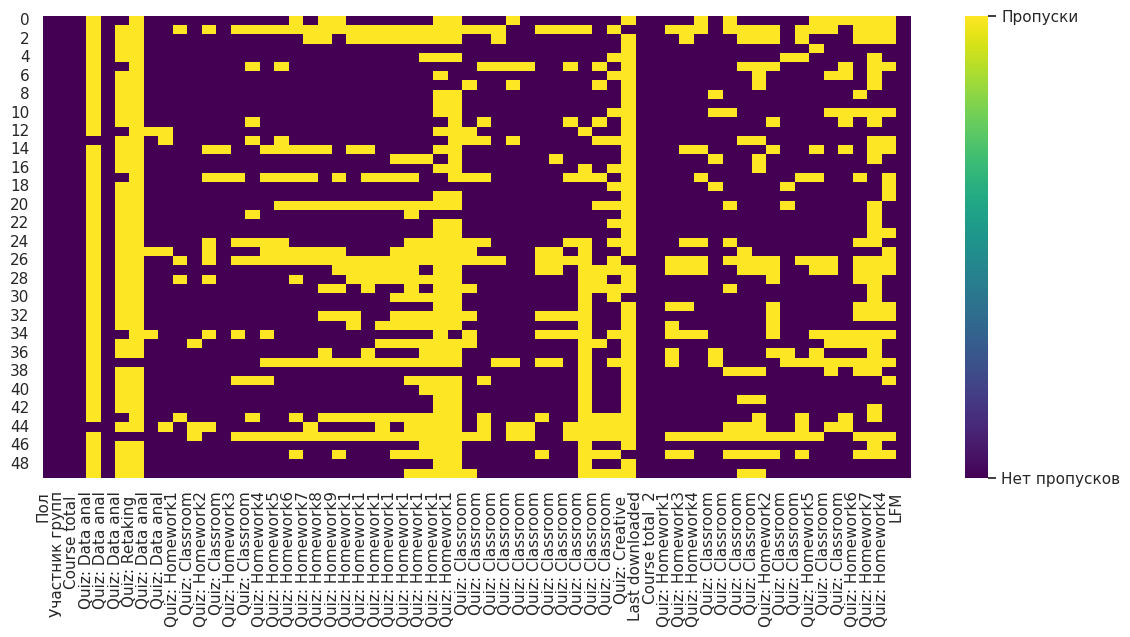

In [130]:
# Создаем тепловую карту, показывающую пропуски
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(raw.isnull(), cmap='viridis') #, cbar_kws={'label': 'Пропуски'})

# Обрезаем подписи по оси X до 15 символов
short_labels = [label[:15] for label in raw.columns]

# Обновляем метки по оси X, чтобы совпадали с количеством отображаемых значений
heatmap.set_xticks(range(len(short_labels)))  # Устанавливаем позицию меток
heatmap.set_xticklabels(short_labels, rotation=90)  # Устанавливаем обрезанные метки без поворота

# Настройка бокового бара
cbar = heatmap.collections[0].colorbar  # Получаем цветовую карту правильно
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Нет пропусков', 'Пропуски'])

plt.show()

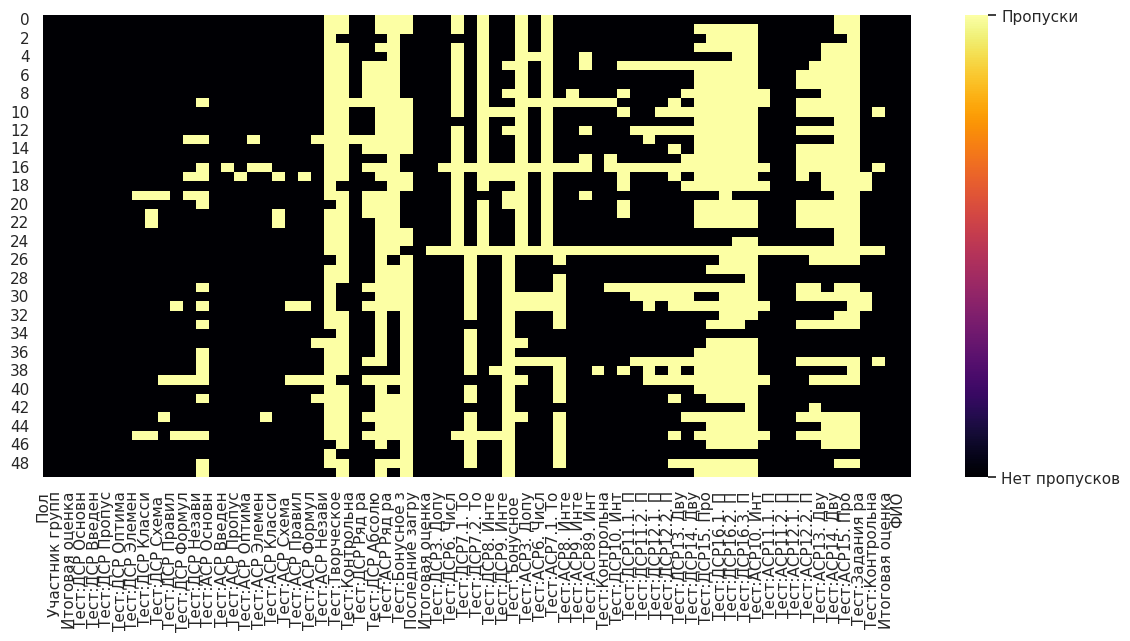

In [131]:
# Создаем тепловую карту, показывающую пропуски
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(data.isnull(), cmap='inferno') #, cbar_kws={'label': 'Пропуски'})

# Обрезаем подписи по оси X до 15 символов
short_labels = [label[:15] for label in data.columns]

# Обновляем метки по оси X, чтобы совпадали с количеством отображаемых значений
heatmap.set_xticks(range(len(short_labels)))  # Устанавливаем позицию меток
heatmap.set_xticklabels(short_labels, rotation=90)  # Устанавливаем обрезанные метки без поворота

# Настройка бокового бара
cbar = heatmap.collections[0].colorbar  # Получаем цветовую карту правильно
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Нет пропусков', 'Пропуски'])

plt.show()

In [132]:
raw=raw.fillna(0).dropna(axis=0)
data=data.fillna(0).dropna(axis=0)

In [133]:
num_students = len(raw)

# Находим все колонки с Homework и Classroom test
homework_columns = [col for col in raw.columns if 'Homework' in col]
classroom_test_columns = [col for col in raw.columns if 'Classroom test' in col]

# Общее количество Homework и Classroom test
total_homework = len(homework_columns)
total_classroom_tests = len(classroom_test_columns)

# Средняя оценка по Homework и Classroom test
mean_homework_score = raw[homework_columns].mean(axis=1).mean()
mean_classroom_test_score = raw[classroom_test_columns].mean(axis=1).mean()

# Процент выполнения (по количеству выполненных заданий относительно общего количества)
completed_homework = raw[homework_columns].notna().sum().sum()
completed_classroom_tests = raw[classroom_test_columns].notna().sum().sum()

total_assignments = (total_homework + total_classroom_tests)*num_students
completed_assignments = completed_homework + completed_classroom_tests

#completion_percentage = (completed_assignments / total_assignments) * 100 if total_assignments > 0 else 0

percentage_hw = (completed_homework/(total_homework*num_students)) * 100 if total_assignments > 0 else 0
percentage_ct = (completed_classroom_tests /(total_classroom_tests*num_students)) * 100 if total_assignments > 0 else 0

# Вывод результатов
print(f'Общее количество Homework: {total_homework}')
print(f'Общее количество Classroom tests: {total_classroom_tests}')
#print(f'Завершенных Homework: {completed_homework}')
#print(f'Завершенных Classroom tests: {completed_classroom_tests}')
print(f'Средняя оценка по Homework: {mean_homework_score:.2f}')
print(f'Средняя оценка по Classroom tests: {mean_classroom_test_score:.2f}')
print(f'Процент выполнения homework: {percentage_hw:.2f}%')
print(f'Процент выполнения classroom tests: {percentage_ct:.2f}%')

Общее количество Homework: 25
Общее количество Classroom tests: 22
Средняя оценка по Homework: 0.25
Средняя оценка по Classroom tests: 0.55
Процент выполнения homework: 100.00%
Процент выполнения classroom tests: 100.00%


In [134]:
num_students = len(data)

# Находим все колонки с Homework и Classroom test
homework_columns = [col for col in data.columns if 'ДСР' in col]
classroom_test_columns = [col for col in data.columns if 'АСР' in col]

# Общее количество Homework и Classroom test
total_homework = len(homework_columns)
total_classroom_tests = len(classroom_test_columns)

# Средняя оценка по Homework и Classroom test
mean_homework_score = data[homework_columns].mean(axis=1).mean()
mean_classroom_test_score = data[classroom_test_columns].mean(axis=1).mean()

# Процент выполнения (по количеству выполненных заданий относительно общего количества)
completed_homework = data[homework_columns].notna().sum().sum()
completed_classroom_tests = data[classroom_test_columns].notna().sum().sum()

total_assignments = (total_homework + total_classroom_tests)*num_students
completed_assignments = completed_homework + completed_classroom_tests

#completion_percentage = (completed_assignments / total_assignments) * 100 if total_assignments > 0 else 0

percentage_hw = (completed_homework/(total_homework*num_students)) * 100 if total_assignments > 0 else 0
percentage_ct = (completed_classroom_tests /(total_classroom_tests*num_students)) * 100 if total_assignments > 0 else 0

# Вывод результатов
print(f'Общее количество Homework: {total_homework}')
print(f'Общее количество Classroom tests: {total_classroom_tests}')
#print(f'Завершенных Homework: {completed_homework}')
#print(f'Завершенных Classroom tests: {completed_classroom_tests}')
print(f'Средняя оценка по Homework: {mean_homework_score:.2f}')
print(f'Средняя оценка по Classroom tests: {mean_classroom_test_score:.2f}')
print(f'Процент выполнения homework: {percentage_hw:.2f}%')
print(f'Процент выполнения classroom tests: {percentage_ct:.2f}%')

Общее количество Homework: 29
Общее количество Classroom tests: 25
Средняя оценка по Homework: 0.31
Средняя оценка по Classroom tests: 0.69
Процент выполнения homework: 100.00%
Процент выполнения classroom tests: 100.00%


In [135]:
# Улучшенный подсчет выполненных работ
def count_completed_works(row, prefix):
    # Ищем столбцы, содержащие указанный префикс (Homework или Classroom)
    cols = [col for col in raw.columns if prefix.lower() in col.lower()]
    # Считаем непустые значения в этих столбцах
    return row[cols].notna().sum()

# Применяем функцию для каждого студента
if len(homework_columns) > 0:
    raw['Completed_Homework'] = raw.apply(lambda x: count_completed_works(x, 'Homework'), axis=1)

if len(classroom_test_columns) > 0:
    raw['Completed_Classroom'] = raw.apply(lambda x: count_completed_works(x, 'Classroom'), axis=1)

# Проверяем данные перед выводом статистики
print("\nПроверка данных:")
print(raw[['Completed_Homework', 'Completed_Classroom']].describe())

# Выводим исправленную статистику
print("\nИсправленная статистика выполненных работ:")
if 'Completed_Homework' in raw.columns:
    print(f"Всего домашних заданий: {len(homework_columns)}")
    print(f"Среднее выполненных домашних заданий: {raw['Completed_Homework'].mean():.2f}")
    print(f"Максимум выполненных: {int(raw['Completed_Homework'].max())}")  # Преобразуем в целое
    print(f"Минимум выполненных: {int(raw['Completed_Homework'].min())}\n")  # Преобразуем в целое

if 'Completed_Classroom' in raw.columns:
    print(f"Всего классных работ: {len(classroom_test_columns)}")
    print(f"Среднее выполненных классных работ: {raw['Completed_Classroom'].mean():.2f}")
    print(f"Максимум выполненных: {int(raw['Completed_Classroom'].max())}")  # Преобразуем в целое
    print(f"Минимум выполненных: {int(raw['Completed_Classroom'].min())}\n")  # Преобразуем в целое


Проверка данных:
       Completed_Homework  Completed_Classroom
count                50.0                 50.0
mean                 25.0                 22.0
std                   0.0                  0.0
min                  25.0                 22.0
25%                  25.0                 22.0
50%                  25.0                 22.0
75%                  25.0                 22.0
max                  25.0                 22.0

Исправленная статистика выполненных работ:
Всего домашних заданий: 29
Среднее выполненных домашних заданий: 25.00
Максимум выполненных: 25
Минимум выполненных: 25

Всего классных работ: 25
Среднее выполненных классных работ: 22.00
Максимум выполненных: 22
Минимум выполненных: 22



# Облако тэгов

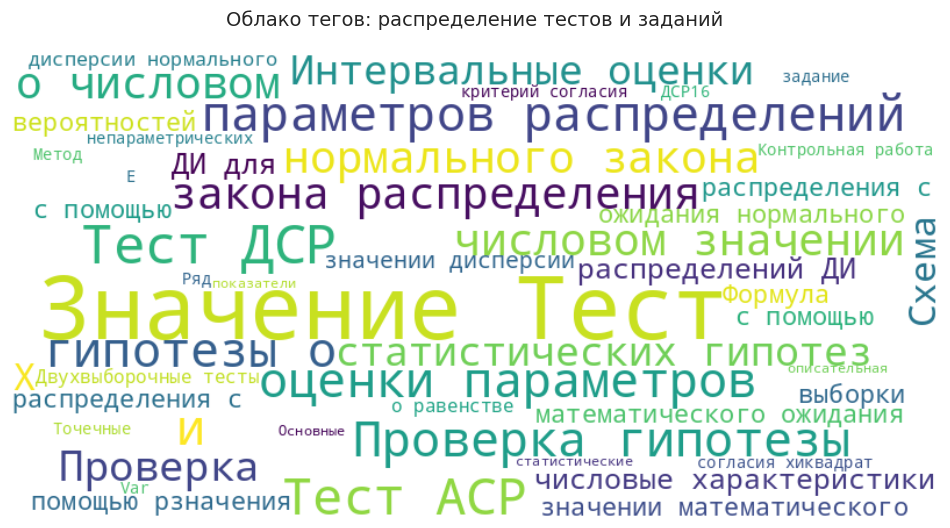

In [136]:
# Выбираем только колонки с Quiz/Assignment (игнорируем личные данные)
quiz_cols = [col for col in data.columns if 'Тест:' in col]

# Собираем все названия тестов/заданий в один текст
text = ' '.join([col.replace('Quiz:', '').strip() for col in quiz_cols])

# Создаем облако тегов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',  # Цветовая схема
    max_words=50,
    contour_width=1,
    contour_color='steelblue'
).generate(text)

# Отображаем
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако тегов: распределение тестов и заданий', pad=20, fontsize=14)
plt.show()

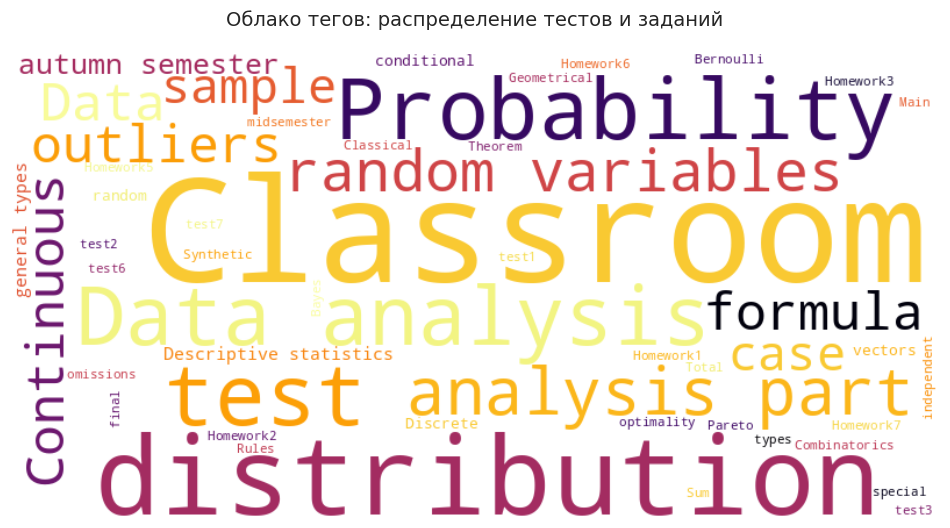

In [137]:
# Выбираем только колонки с Quiz/Assignment (игнорируем личные данные)
quiz_cols = [col for col in raw.columns if 'Quiz:' in col or 'Assignment:' in col]

# Собираем все названия тестов/заданий в один текст
text = ' '.join([col.replace('Quiz:', '').replace('Assignment:', '').strip() for col in quiz_cols])

# Создаем облако тегов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='inferno',  # Цветовая схема
    max_words=50,
    contour_width=1,
    contour_color='steelblue'
).generate(text)

# Отображаем
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако тегов: распределение тестов и заданий', pad=20, fontsize=14)
plt.show()

# Корреляция

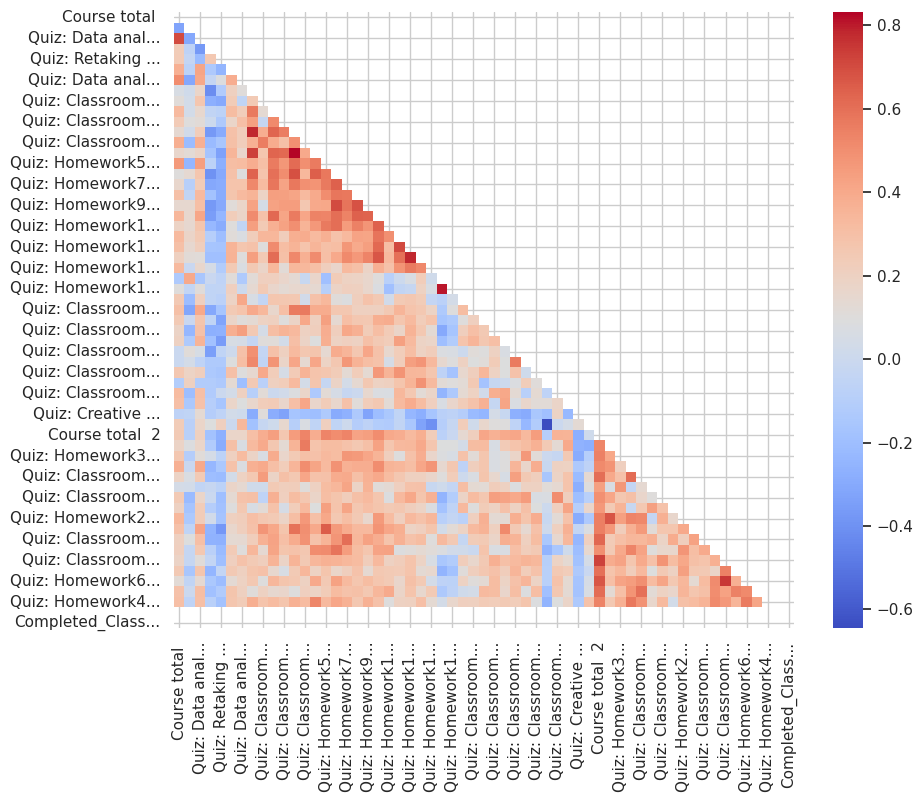

In [138]:
# Фильтруем столбцы с заполненностью >50%
threshold = 0.5 * len(raw)
filtered_columns = raw.columns[raw.notna().sum() > threshold]
filtered_data = raw[filtered_columns]

# Вычисляем корреляцию только для отфильтрованных числовых столбцов
corr_matrix = filtered_data.select_dtypes(include=[np.number]).corr()


# Create a mask to hide the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) #|(np.abs(corr_matrix) >= 0.9))

# Обрезаем длинные названия столбцов (первые 15 символов)
short_names = [name[:15] + ('...' if len(name) > 15 else '') for name in corr_matrix.columns]
corr_matrix.columns = short_names
corr_matrix.index = short_names

# Plot the upper triangle of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm')
plt.show()

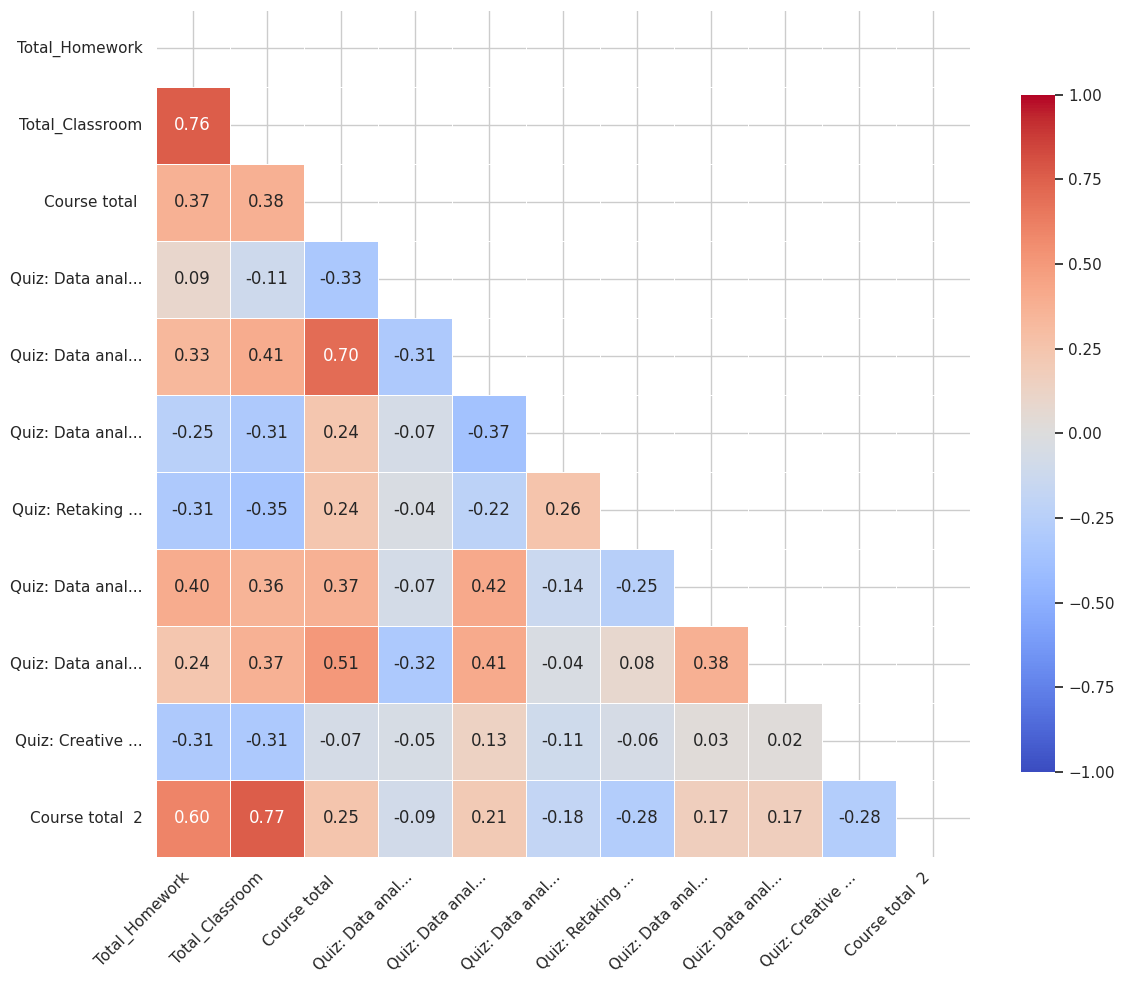

In [139]:
df=raw.copy().fillna(0)
# 1. Выделим домашние задания (Homework) и классные работы (Classroom)
hw_cols = [col for col in df.columns if 'Homework' in col]
classroom_cols = [col for col in df.columns if 'Classroom' in col]

# 2. Рассчитаем суммарные баллы для каждого студента
df['Total_Homework'] = df[hw_cols].sum(axis=1)
df['Total_Classroom'] = df[classroom_cols].sum(axis=1)

# 3. Создадим обобщенную матрицу признаков
features = ['Total_Homework', 'Total_Classroom']

# Добавим другие значимые числовые характеристики (если есть)
numeric_cols = df.select_dtypes(include=[np.number]).columns
exclude_cols = hw_cols + classroom_cols + ['Total_Homework', 'Total_Classroom', 'Last downloaded from this course']
features.extend([col for col in numeric_cols if col not in exclude_cols])

# 4. Построим корреляционную матрицу
corr_matrix = df[features].corr()

# Обрезаем длинные названия столбцов (первые 15 символов)
short_names = [name[:15] + ('...' if len(name) > 15 else '') for name in corr_matrix.columns]
corr_matrix.columns = short_names
corr_matrix.index = short_names

# 5. Визуализация
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": 0.8}
)

# plt.title('Обобщенная корреляционная матрица\n(включая суммарные баллы за Homework и Classroom)', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

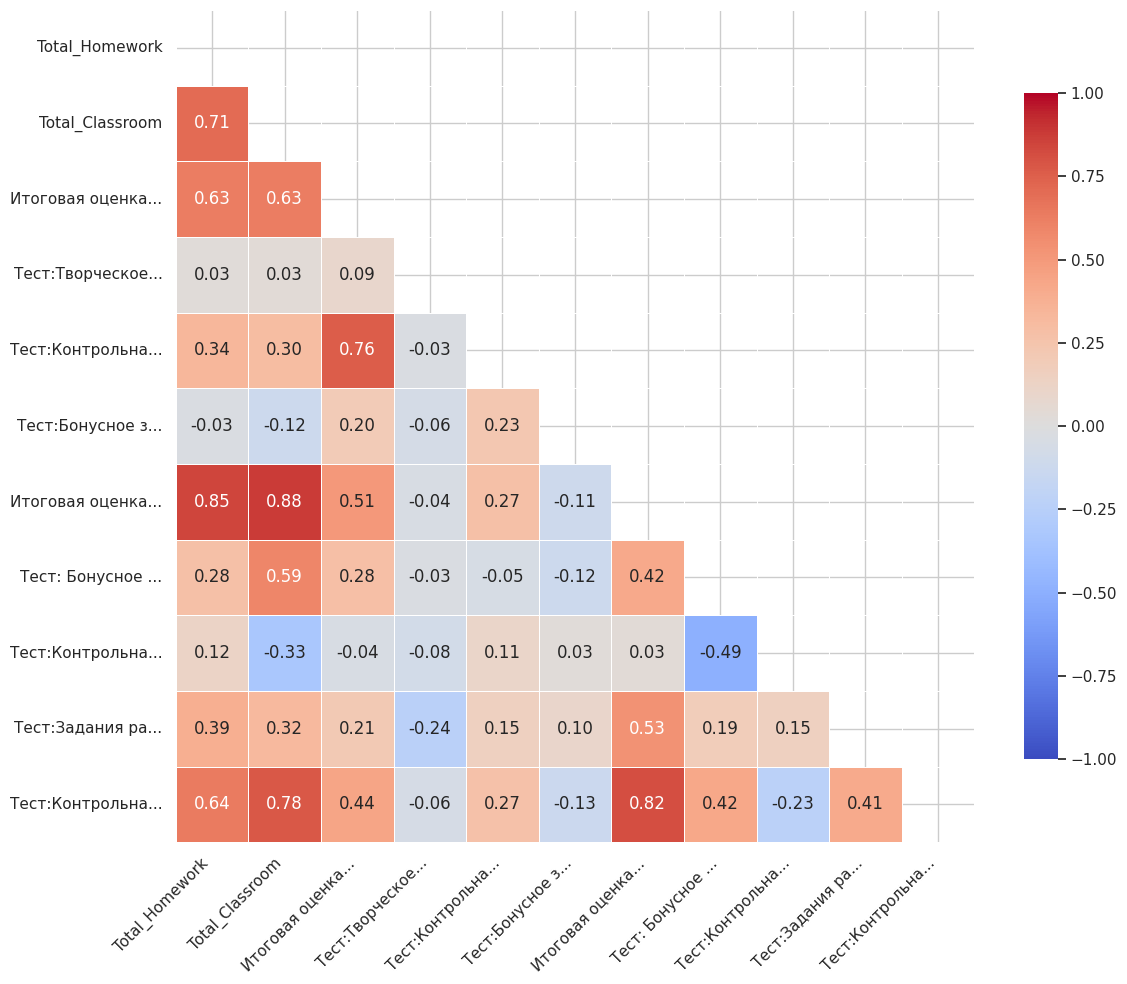

In [140]:
frame=data.copy().fillna(0)
# 1. Выделим домашние задания (Homework) и классные работы (Classroom)
hw_cols = [col for col in frame.columns if 'ДСР' in col]
classroom_cols = [col for col in frame.columns if 'АСР' in col]

# 2. Рассчитаем суммарные баллы для каждого студента
frame['Total_Homework'] = frame[hw_cols].sum(axis=1)
frame['Total_Classroom'] = frame[classroom_cols].sum(axis=1)

# 3. Создадим обобщенную матрицу признаков
features = ['Total_Homework', 'Total_Classroom']

# Добавим другие значимые числовые характеристики (если есть)
numeric_cols = frame.select_dtypes(include=[np.number]).columns
exclude_cols = hw_cols + classroom_cols + ['Total_Homework', 'Total_Classroom', 'Итог', 'Итоговая оценка за курс','Последние загруженные из этого курса']
features.extend([col for col in numeric_cols if col not in exclude_cols])

# 4. Построим корреляционную матрицу
corr_matrix = frame[features].corr()

# Обрезаем длинные названия столбцов (первые 15 символов)
short_names = [name[:15] + ('...' if len(name) > 15 else '') for name in corr_matrix.columns]
corr_matrix.columns = short_names
corr_matrix.index = short_names

# 5. Визуализация
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": 0.8}
)

#plt.title('Обобщенная корреляционная матрица\n(включая суммарные баллы за Homework и Classroom)', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Проверка значимости коэффициента корреляции

In [141]:
x=df['Total_Homework']
y=df['Total_Classroom']

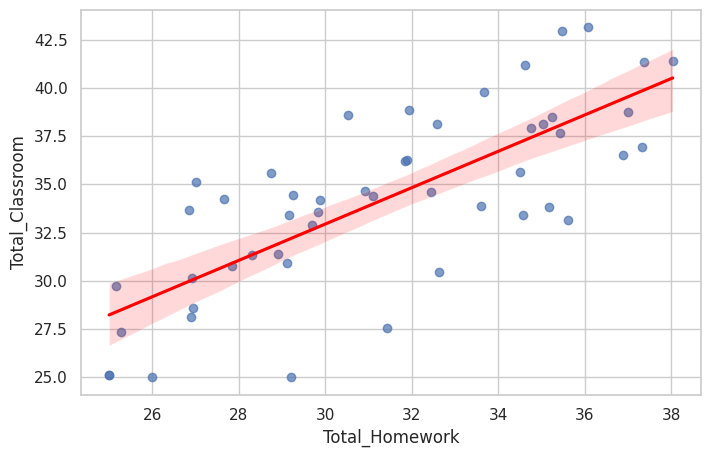

In [142]:
plt.figure(figsize=(8, 5))
#sns.scatterplot(x=frame['Total_Homework'], y=frame['Total_Classroom'], alpha=0.7)
sns.regplot(x=x, y=y, scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})

#plt.title('Зависимость Total_Homework и Total_Classroom с линией регрессии')
plt.xlabel('Total_Homework')
plt.ylabel('Total_Classroom')
plt.grid(True)
plt.show()

In [143]:
# Тест Шапиро-Уилка на нормальность
shapiro_x = stats.shapiro(x)
shapiro_y = stats.shapiro(y)
print(f"Shapiro-Wilk p-value (X): {shapiro_x.pvalue:.3f}")
print(f"Shapiro-Wilk p-value (Y): {shapiro_y.pvalue:.3f}")
# Интерпретация результатов
alpha = 0.05  # Уровень значимости
if shapiro_x.pvalue > alpha and shapiro_y.pvalue > alpha:
    print("Обе переменные (X и Y) имеют распределение, близкое к нормальному (p > 0.05).")
elif shapiro_x.pvalue <= alpha and shapiro_y.pvalue > alpha:
    print("Переменная X не распределена нормально (p <= 0.05), а переменная Y имеет нормальное распределение (p > 0.05).")
elif shapiro_x.pvalue > alpha and shapiro_y.pvalue <= alpha:
    print("Переменная X имеет нормальное распределение (p > 0.05), а переменная Y не распределена нормально (p <= 0.05).")
else:
    print("Обе переменные (X и Y) не распределены нормально (p <= 0.05).")

Shapiro-Wilk p-value (X): 0.050
Shapiro-Wilk p-value (Y): 0.302
Обе переменные (X и Y) имеют распределение, близкое к нормальному (p > 0.05).


In [144]:
r, p_value = stats.pearsonr(x, y)
print(f"Коэффициент корреляции Пирсона: {r:.3f}")
print(f"p-value: {p_value:.15f}")
if p_value<0.05: print('отвергаем H₀ и принимаем Н1: корреляция значима!')
else: print('принимаем H₀: корреляция в генеральной совокупности отсутствует')

Коэффициент корреляции Пирсона: 0.762
p-value: 0.000000000128928
отвергаем H₀ и принимаем Н1: корреляция значима!


# Распределения

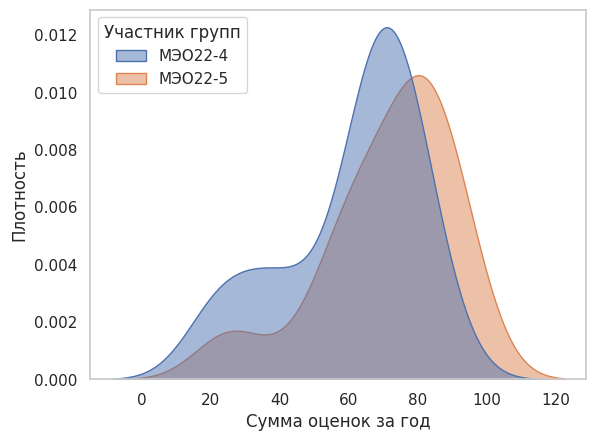

In [145]:
frame=data.copy()
# Преобразуем данные в длинный формат для удобства
long_frame = frame.melt(id_vars=['Участник групп'], value_vars=['Итоговая оценка за курс'],
                  var_name='Course Type', value_name='Score')

# Построение графика с использованием hue
#sns.kdeplot(data=long_frame, x='Score',  common_norm=False, fill=True, alpha=0.5)
sns.kdeplot(data=long_frame, x='Score', hue='Участник групп', legend=True,  common_norm=True, # bw_adjust=2,
             fill=True, alpha=0.5)

# Настройки графика
#plt.title('Распределение Course total 1 по группам')
plt.xlabel('Сумма оценок за год')
plt.ylabel('Плотность')
plt.grid()
plt.show()

In [146]:
df = raw.copy()
# Функция для выделения первого вхождения "МБНиА231" или "МБНиА232"
def extract_first_group(group_str):
    parts = [group for group in group_str.split('МБНиА23') if group]
    if parts:
        first_group = 'МБНиА23' + parts[0][:1]  # Возвращаем первое вхождение (с одним символом)
        return first_group
    return group_str  # Возвращаем оригинальную строку, если ничего не найдено

# Применяем функцию к столбцу 'Участник групп'
df['Участник групп'] = df['Участник групп'].apply(extract_first_group)

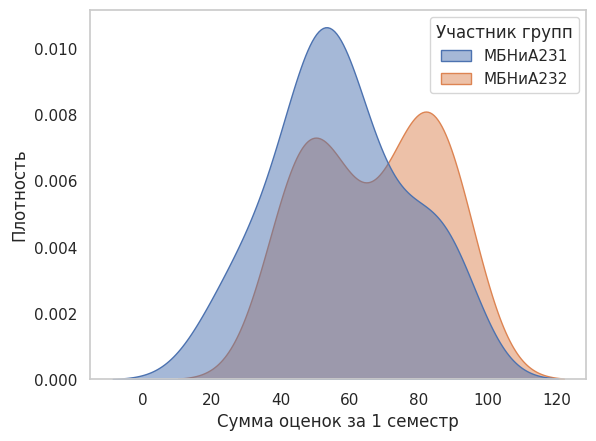

In [147]:
# Преобразуем данные в длинный формат для удобства
long_df = df.melt(id_vars=['Участник групп'], value_vars=['Course total '],
                  var_name='Course Type', value_name='Score')

# Построение графика с использованием hue
#sns.kdeplot(data=long_df, x='Score', common_norm=False, fill=True, alpha=0.5)
sns.kdeplot(data=long_df, x='Score', hue='Участник групп', legend=True,  common_norm=True, warn_singular=False, # bw_adjust=2,
             fill=True, alpha=0.5)

# Настройки графика
#plt.title('Распределение Course total 1 по группам')
plt.xlabel('Сумма оценок за 1 семестр')
plt.ylabel('Плотность')
plt.grid()
plt.show()

## Тест Манна-Уитни для различия медиан выборок

<Axes: xlabel='Итог', ylabel='Density'>

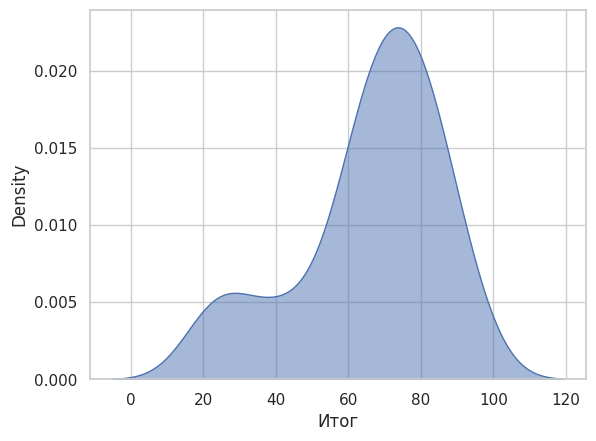

In [148]:
data['Итог']=data['Итоговая оценка за курс']
X=data[['Итог','Пол', 'Участник групп']]
# Создаём и применяем StandardScaler
scaler = StandardScaler()
sns.kdeplot(data=X, x='Итог', common_norm=False, fill=True, alpha=0.5)

<Axes: xlabel='Итог', ylabel='Density'>

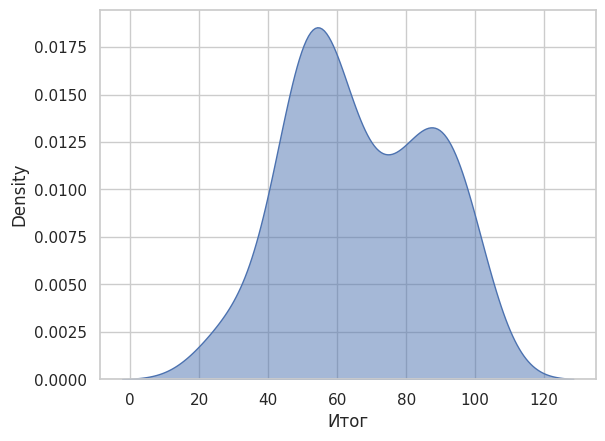

In [149]:
df['Итог']=df['Course total ']+df['Course total  2']
Y=df[['Итог','Пол', 'Участник групп']]
# Создаём и применяем StandardScaler
scaler = StandardScaler()
#Y.loc[:, 'Итог'] = scaler.fit_transform(X[['Итог']])
sns.kdeplot(data=Y, x='Итог',  common_norm=False, fill=True, alpha=0.5)

In [150]:
sample_eng=X['Итог'].fillna(0)
sample_rus=Y['Итог'].fillna(0)

# Выполнение теста Манна-Уитни
statistic, p_value = mannwhitneyu(sample_eng, sample_rus, alternative='two-sided')

# Вывод результатов
print(f"Статистика теста: {statistic}")
print(f"p-значение: {p_value}")

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: медианы выборок значимо отличаются.")
else:
    print("Не отвергаем нулевую гипотезу: медианы выборок не значимо отличаются.")

Статистика теста: 1284.0
p-значение: 0.8173585726127014
Не отвергаем нулевую гипотезу: медианы выборок не значимо отличаются.


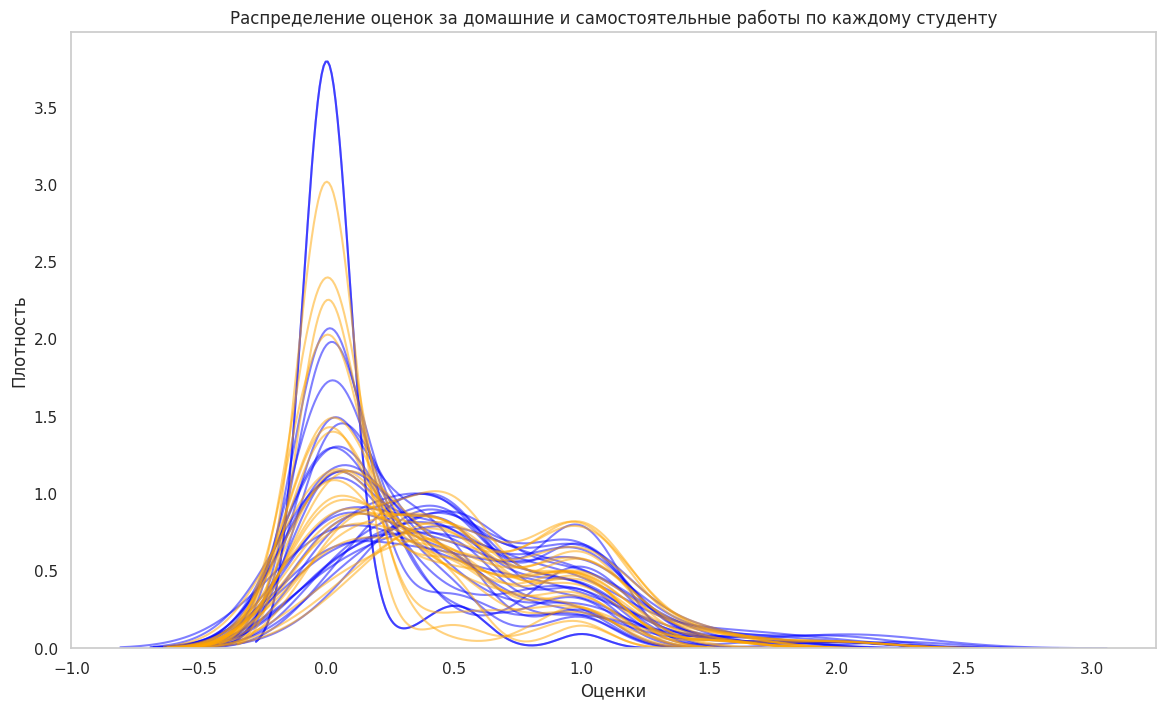

In [151]:
quiz_columns = [col for col in df.columns if col.startswith('Quiz: Homework') or col.startswith('Quiz: Classroom')]

# Установка стиля графика
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(14, 8))

color_map = {
    'МБНиА231': 'blue',
    'МБНиА232': 'orange'
}

# Итерация по каждому студенту
for index, row in df.iterrows():
    group = row['Участник групп']  # Получаем группу студента
    sns.kdeplot(data=row[quiz_columns], fill=False, alpha=0.5, color=color_map[group], warn_singular=False)

# Настройки графика
plt.title('Распределение оценок за домашние и самостоятельные работы по каждому студенту')
plt.xlabel('Оценки')
plt.ylabel('Плотность')
plt.grid()

# Кластеризация студентов по траекториям обучения

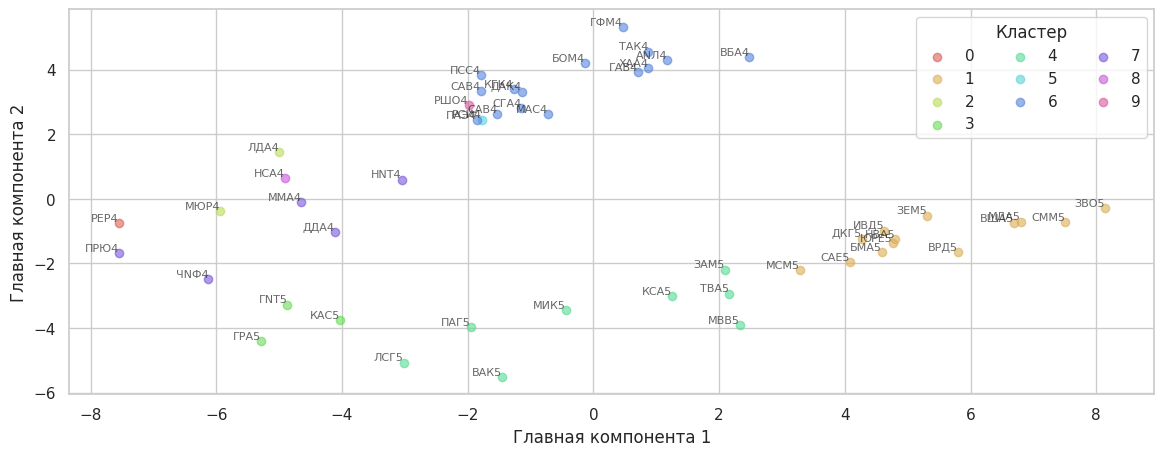

10
Инерция: 1594.08
Индекс Силуэта: 0.13
Индекс Дэвида-Болдвина: 1.24


In [152]:
dff=data.copy()
# Заполнение отсутствующих значений
#dff['Отчество'] = dff['Отчество'].fillna('N')  # Заполнить пробелом, если отсутствует
#dff=dff.fillna(0).dropna(axis=1)

dff['Code'] = dff['ФИО']+dff['Участник групп'].str[-1]
X = dff.drop(columns=['Code','ФИО', 'Пол', 'Участник групп'], axis=1)
dff=dff.fillna(0)
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Стандартизируем данные

n_clusters=10
kmeans = KMeans(n_clusters=n_clusters, n_init=1)
kmeans.fit(X_scaled)

# Прогнозирование кластеров
clusters = kmeans.predict(X_scaled)
dff['cluster'] = clusters

# PCA для уменьшения размерности
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)  # Применяем PCA к стандартизированным данным

# Визуализация
plt.figure(figsize=(14, 5))
colors = sns.color_palette("hls", n_clusters)

for cluster_id in range(n_clusters):
    plt.scatter(X_2d[clusters == cluster_id, 0], X_2d[clusters == cluster_id, 1],
                label=f'{cluster_id}', color=colors[cluster_id], alpha=0.6)

    # Добавление текста для каждого кластера
    for index, (x, y) in enumerate(X_2d[clusters == cluster_id]):
        plt.text(x, y, str(dff[dff['cluster'] == cluster_id]['Code'].values[index]),
                 fontsize=8, ha='right', va='bottom', alpha=0.7)

plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title='Кластер', loc='best',  ncol=3)
plt.show()

print(n_clusters)
print(f'Инерция: {kmeans.inertia_:.2f}')
print(f'Индекс Силуэта: {metrics.silhouette_score(X_scaled, clusters):.2f}')  # Используйте X_scaled вместо X
print(f'Индекс Дэвида-Болдвина: {metrics.davies_bouldin_score(X_scaled, clusters):.2f}')  # Используйте X_scaled вместо X

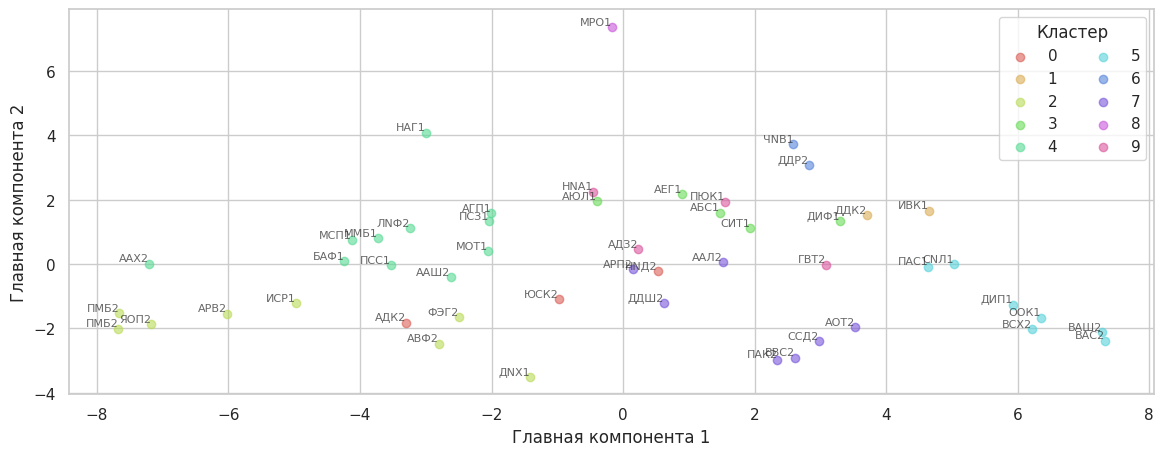

10
Инерция: 1542.38
Индекс Силуэта: 0.05
Индекс Дэвида-Болдвина: 1.94


In [153]:
dff=raw.copy()
dff['Code'] = dff['LFM']+dff['Участник групп'].str[-1]
X = dff.drop(columns=['Code','LFM','Пол', 'Участник групп'], axis=1)
dff=dff.fillna(0)
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Стандартизируем данные

n_clusters=10
kmeans = KMeans(n_clusters=n_clusters, n_init=1)
kmeans.fit(X_scaled)

# Прогнозирование кластеров
clusters = kmeans.predict(X_scaled)
dff['cluster'] = clusters

# PCA для уменьшения размерности
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)  # Применяем PCA к стандартизированным данным

# Визуализация
plt.figure(figsize=(14, 5))
colors = sns.color_palette("hls", n_clusters)

for cluster_id in range(n_clusters):
    plt.scatter(X_2d[clusters == cluster_id, 0], X_2d[clusters == cluster_id, 1],
                label=f'{cluster_id}', color=colors[cluster_id], alpha=0.6)

    # Добавление текста для каждого кластера
    for index, (x, y) in enumerate(X_2d[clusters == cluster_id]):
        plt.text(x, y, str(dff[dff['cluster'] == cluster_id]['Code'].values[index]),
                 fontsize=8, ha='right', va='bottom', alpha=0.7)

plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title='Кластер', loc='best',  ncol=2)
plt.show()

print(n_clusters)
print(f'Инерция: {kmeans.inertia_:.2f}')
print(f'Индекс Силуэта: {metrics.silhouette_score(X_scaled, clusters):.2f}')  # Используйте X_scaled вместо X
print(f'Индекс Дэвида-Болдвина: {metrics.davies_bouldin_score(X_scaled, clusters):.2f}')  # Используйте X_scaled вместо X


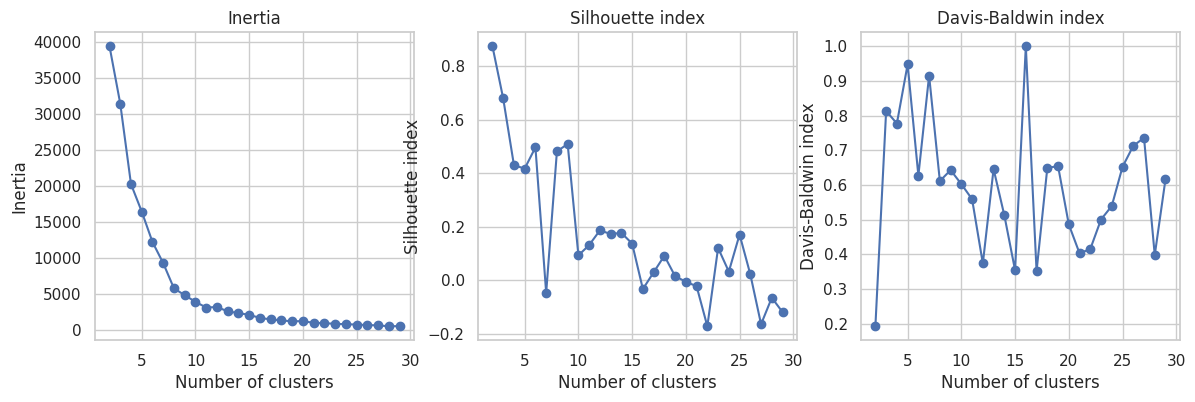

In [154]:
inertia_values = []
silhouette_scores = []
davies_bouldin_scores = []
number=30
for n in range(2, number):
    kmeans = KMeans(n_clusters=n, n_init=1)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_score = metrics.silhouette_score(X, clusters)
    silhouette_scores.append(silhouette_score)

    inertia_values.append(kmeans.inertia_)
    davies_bouldin_score = metrics.davies_bouldin_score(X, clusters)
    davies_bouldin_scores.append(davies_bouldin_score)

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(range(2, number), inertia_values, marker='o')
plt.title('Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.plot(range(2, number), silhouette_scores, marker='o')
plt.title('Silhouette index')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette index')

plt.subplot(1, 3, 3)
plt.plot(range(2, number), davies_bouldin_scores, marker='o')
plt.title('Davis-Baldwin index')
plt.xlabel('Number of clusters')
plt.ylabel('Davis-Baldwin index')

plt.show()